In [8]:
import time
# import lightgbm as lgb
# import xgboost as xgb
import seaborn as sns

# from fastai.imports import *
# from fastai.structured import *
from fbprophet import Prophet

# def ignore_warn(*args, **kwargs):
#     pass
# warnings.warn = ignore_warn

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [19]:
#read from the input file:
import pandas as pd
df_train=pd.read_csv("/Users/chidam/Desktop/train_Store_Item_Demand_Forecasting.csv", parse_dates=['date'], index_col=['date'])



In [20]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [22]:
# there are no missing values in the dataset

(df_train.isnull().sum() * 100)/len(df_train)

store    0.0
item     0.0
sales    0.0
dtype: float64

In [24]:
# how come each store has the same number of records? 
df_train['store'].value_counts()

10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64

In [25]:
df_train['item'].value_counts()

50    18260
13    18260
23    18260
22    18260
21    18260
20    18260
19    18260
18    18260
17    18260
16    18260
15    18260
14    18260
12    18260
49    18260
11    18260
10    18260
9     18260
8     18260
7     18260
6     18260
5     18260
4     18260
3     18260
2     18260
24    18260
25    18260
26    18260
27    18260
48    18260
47    18260
46    18260
45    18260
44    18260
43    18260
42    18260
41    18260
40    18260
39    18260
38    18260
37    18260
36    18260
35    18260
34    18260
33    18260
32    18260
31    18260
30    18260
29    18260
28    18260
1     18260
Name: item, dtype: int64

In [26]:
print("Train shape is {}".format(df_train.shape))

Train shape is (913000, 3)


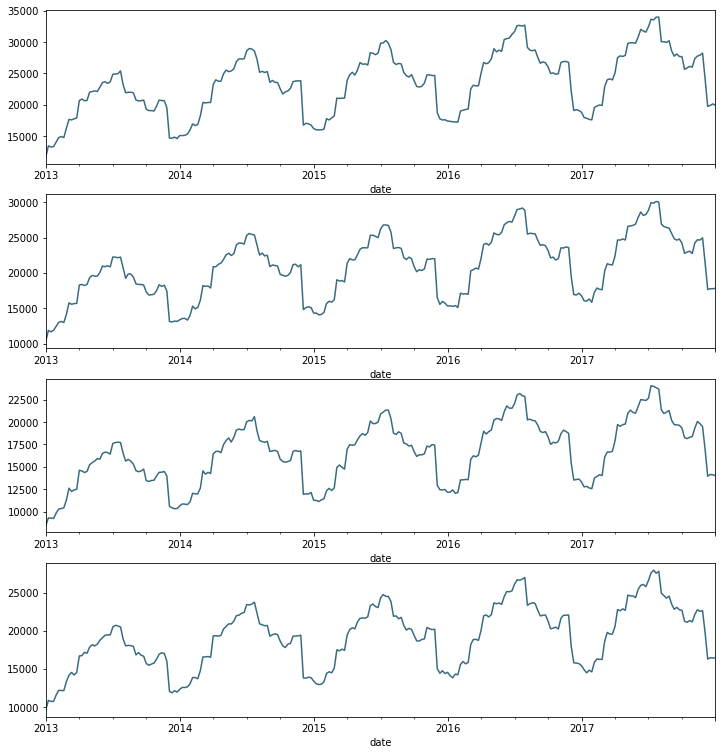

In [28]:
#### Seasonality Check
# preparation: input should be float type
pd.plotting.register_matplotlib_converters()#this fixed the error: TypeError: float() argument must be a string or a number, not 'Period'

df_train['sales'] = df_train['sales'] * 1.0

# store types
sales_a = df_train[df_train.store == 2]['sales'].sort_index(ascending = True)
sales_b = df_train[df_train.store == 3]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df_train[df_train.store == 1]['sales'].sort_index(ascending = True)
sales_d = df_train[df_train.store == 4]['sales'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
c = '#386B7F'

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)#Resample time series data to a weekly interval
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

#All Stores have same trend... Weird Seems like the dataset is A Synthetic One..;

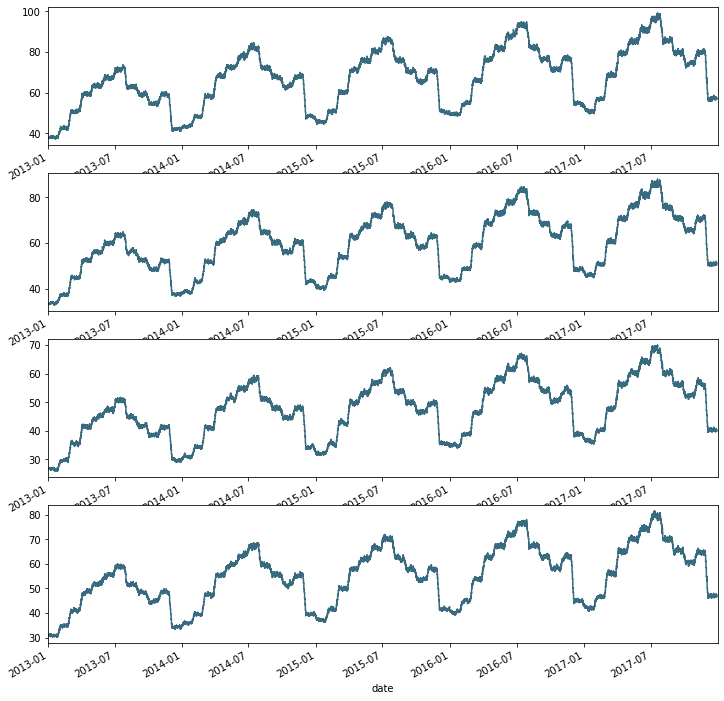

In [29]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Yearly
decomposition_a = sm.tsa.seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = sm.tsa.seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = sm.tsa.seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = sm.tsa.seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

In [30]:
date_sales = df_train.drop(['store','item'], axis=1).copy() #it's a temporary DataFrame.. Original is Still intact..

In [31]:
date_sales.head()

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0


In [38]:
y = date_sales['sales'].resample('MS').mean()#what does "MS" mean here: MS - month start frequency
y['2014':] #sneak peak

date
2014-01-01    33.934645
2014-02-01    37.794071
2014-03-01    45.438774
2014-04-01    52.594267
2014-05-01    56.959806
2014-06-01    60.456133
2014-07-01    63.807097
2014-08-01    57.135226
2014-09-01    52.341600
2014-10-01    48.960194
2014-11-01    53.385533
2014-12-01    37.293419
2015-01-01    35.646000
2015-02-01    39.379786
2015-03-01    47.158129
2015-04-01    54.964467
2015-05-01    59.800129
2015-06-01    62.478933
2015-07-01    66.925806
2015-08-01    59.380710
2015-09-01    54.888800
2015-10-01    51.435677
2015-11-01    55.176333
2015-12-01    39.198194
2016-01-01    38.867032
2016-02-01    42.410828
2016-03-01    51.024581
2016-04-01    60.130000
2016-05-01    63.789032
2016-06-01    68.177600
2016-07-01    73.465677
2016-08-01    63.322194
2016-09-01    59.788733
2016-10-01    55.718516
2016-11-01    59.429867
2016-12-01    42.800710
2017-01-01    39.826194
2017-02-01    44.383500
2017-03-01    53.075290
2017-04-01    62.590800
2017-05-01    65.850710
2017-06-01 

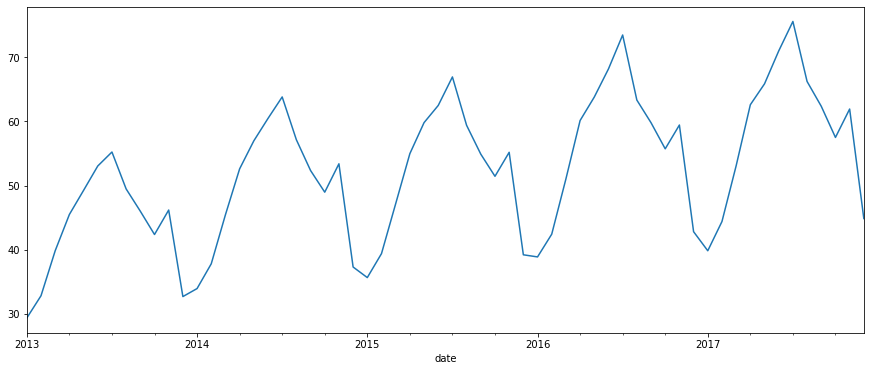

In [36]:
y.plot(figsize=(15, 6),);

#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year
# and again low at the end of the year...
#There is always an upward trend within any single year with a couple of low months in the mid of the year...

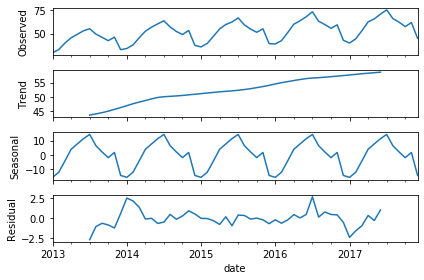

In [39]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality

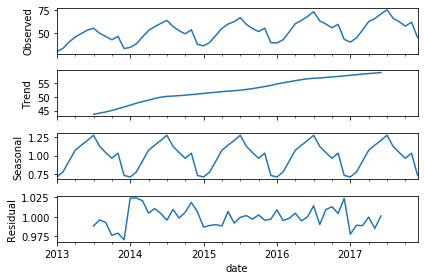

In [40]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
#The plot above clearly shows that the sales is unstable, along with its obvious seasonality.

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot();

In [42]:
# Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the moving average.

# $\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

import numpy as np
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(date_sales, 24) # prediction for the last observed day (past 24 hours)

64.54166666666667

In [46]:
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
        plt.plot(lower_bond, color='Black', alpha=.3)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

In [47]:
#to print rolling_mean for understanding
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()
    print(rolling_mean)

#     plt.figure(figsize=(15,5))
#     plt.title("Moving average\n window size = {}".format(window))
#     plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

#     # Plot confidence intervals for smoothed values
#     if plot_intervals:
#         mae = mean_absolute_error(series[window:], rolling_mean[window:])
#         deviation = np.std(series[window:] - rolling_mean[window:])
#         lower_bond = rolling_mean - (mae + scale * deviation)
#         upper_bond = rolling_mean + (mae + scale * deviation)
#         plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
#         plt.plot(lower_bond, color='Black', alpha=.3)
        
#         # Having the intervals, find abnormal values
#         if plot_anomalies:
#             anomalies = pd.DataFrame(index=series.index, columns=series.columns)
#             anomalies[series<lower_bond] = series[series<lower_bond]
#             anomalies[series>upper_bond] = series[series>upper_bond]
#             plt.plot(anomalies, "ro", markersize=10)
        
#     plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
#     plt.legend(loc="upper left")
#     plt.grid(True)

In [48]:
plotMovingAverage(date_sales, 7)

                sales
date                 
2013-01-01        NaN
2013-01-02        NaN
2013-01-03        NaN
2013-01-04        NaN
2013-01-05        NaN
...               ...
2017-12-27  62.714286
2017-12-28  62.142857
2017-12-29  62.000000
2017-12-30  60.857143
2017-12-31  61.714286

[913000 rows x 1 columns]


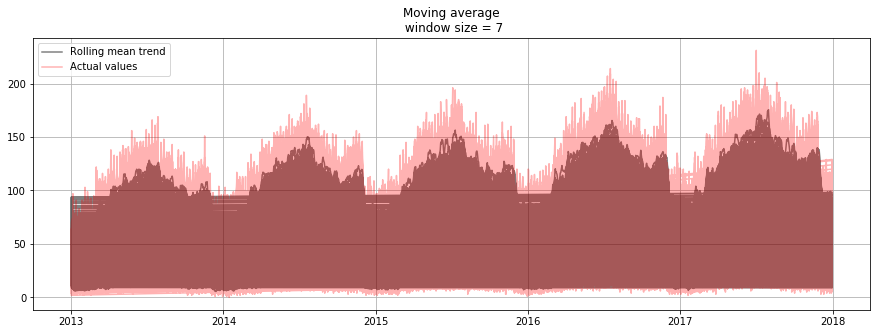

In [44]:
plotMovingAverage(date_sales, 7)

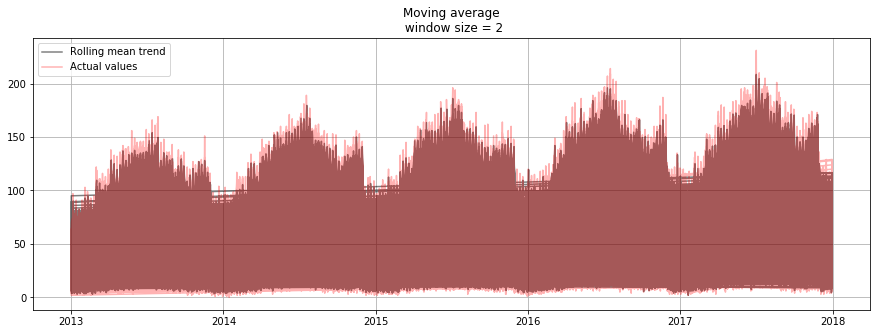

In [45]:
plotMovingAverage(date_sales, 2)

In [ ]:
# Exponential smoothing
# Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all
# available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

# $$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [49]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [50]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual", alpha = 0.4)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

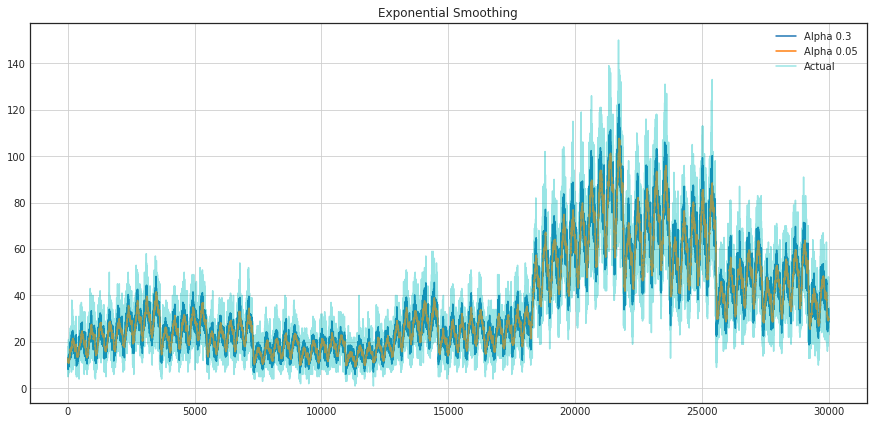

In [51]:
plotExponentialSmoothing(date_sales.sales[:30000], [0.3, 0.05])

In [ ]:
# Double exponential Smoothing
# Up to now, the methods that we've have seen are for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

# Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

# $$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

# $$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

# $$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series.
The second term is now split into previous values of the level and of the trend.
The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing.
The final prediction is the sum of the model values of the intercept and trend.

In [57]:
# Double exponential Smoothing

def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.1)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

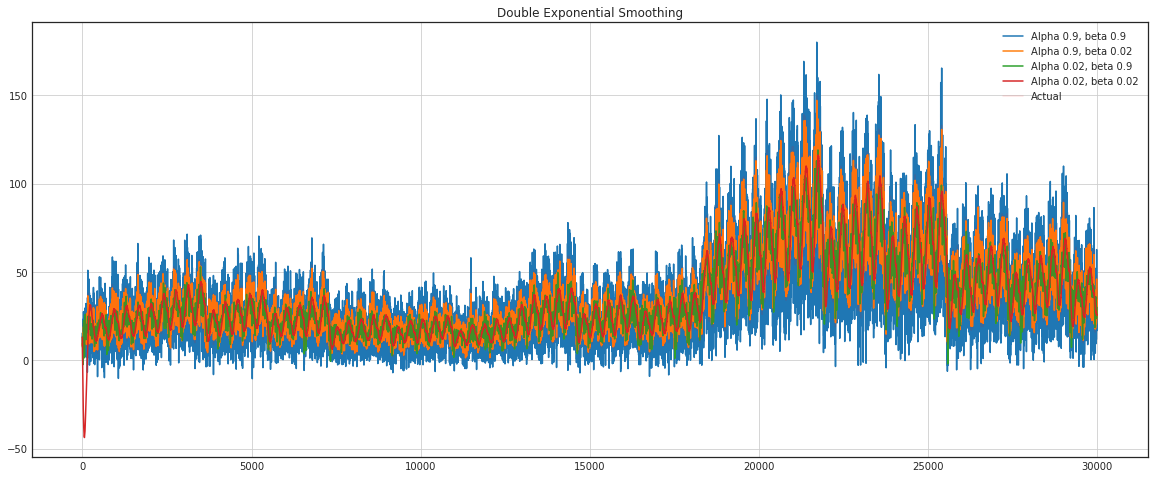

In [58]:
plotDoubleExponentialSmoothing(date_sales.sales[:30000], alphas=[0.9, 0.02], betas=[0.9, 0.02])

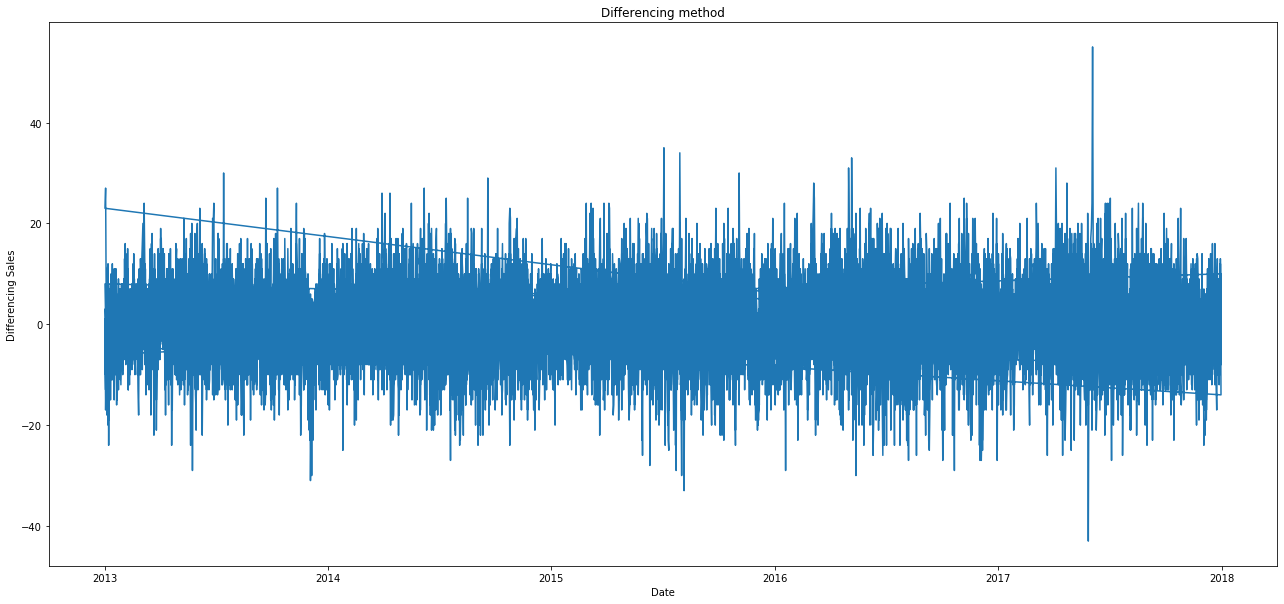

In [54]:
What is the use of this chart here?

ts_diff = date_sales - date_sales.shift(7)
plt.figure(figsize=(22,10))
plt.plot(ts_diff[:20000])
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Sales");

In [60]:
df_test=pd.read_csv("/Users/chidam/Desktop/test_Store_Item_Demand_Forecasting.csv", parse_dates=['date'], index_col=['date'])
df_test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [61]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [75]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64


    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
#     print(fldname)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
#     print(targ_pre )
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
#         print(df[targ_pre + n])
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)



In [76]:
add_datepart(df_train,'date',False)
add_datepart(df_test,'date',False)

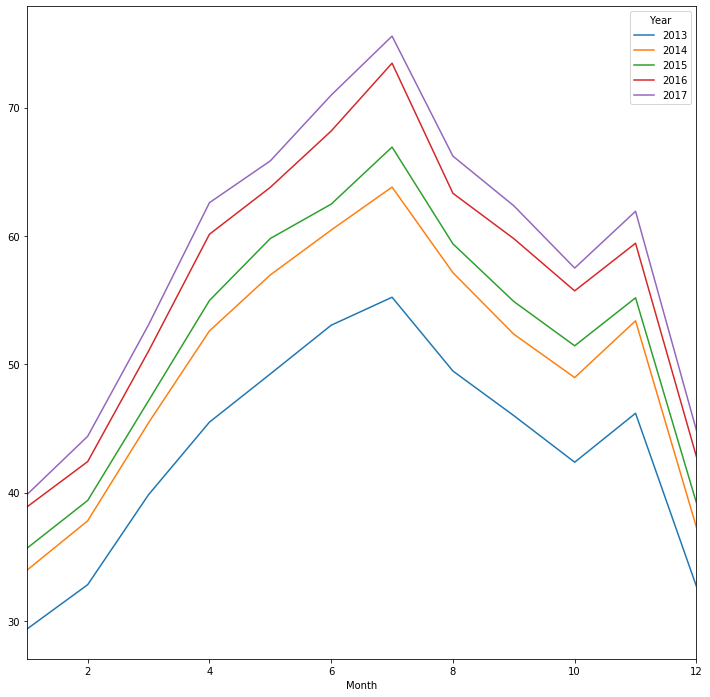

In [77]:
Pivoted plots

pivoted = pd.pivot_table(df_train, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

In [ ]:
From the above graph it looks like the month July scores high with re to sales in all years. With year over year sales 
following an increasing trend no wonder 2017 July topping the chart. The next big sales event seems to happen in November 
across all the years.

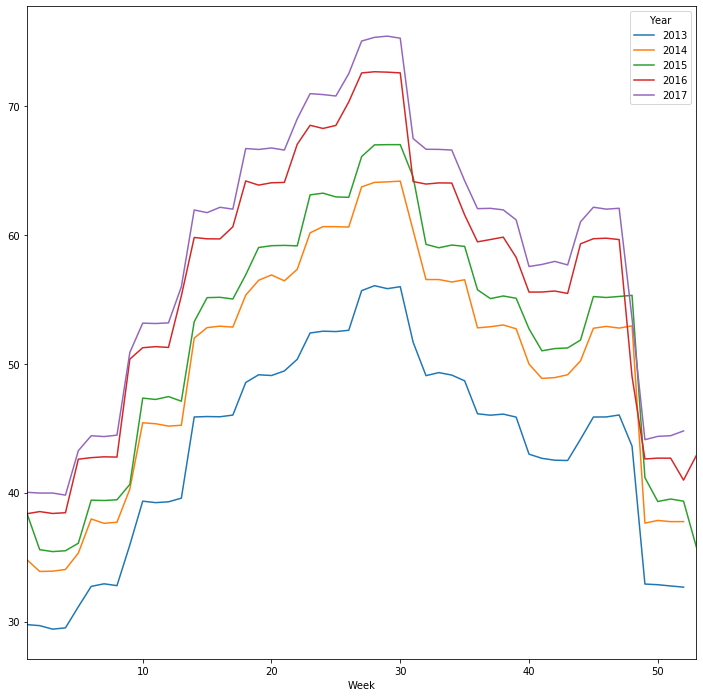

In [78]:
pivoted = pd.pivot_table(df_train, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

In [ ]:
pivoted = pd.pivot_table(df_train, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

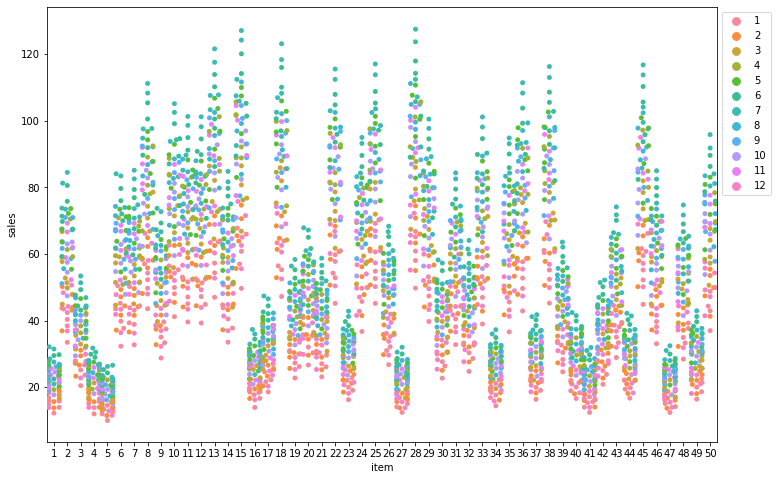

In [79]:
temp_1 = df_train.groupby(['Year','Month','item'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8))
sns.swarmplot('item', 'sales', data=temp_1, hue = 'Month');
# Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2);

In [85]:
temp_1.head()

,Year,sales
0,2013,43.513660
1,2014,50.057436
2,2015,52.256915
3,2016,56.596503
4,2017,58.815014


In [86]:
df_train.head()

,date,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2013-01-01,1,1,13.0,2013,1,1,1,1,1,1,False,True,False,True,False,True
1,2013-01-02,1,1,11.0,2013,1,1,2,2,2,1,False,False,False,False,False,False
2,2013-01-03,1,1,14.0,2013,1,1,3,3,3,1,False,False,False,False,False,False
3,2013-01-04,1,1,13.0,2013,1,1,4,4,4,1,False,False,False,False,False,False
4,2013-01-05,1,1,10.0,2013,1,1,5,5,5,1,False,False,False,False,False,False


In [84]:
#In case the above plot is clutterd(which it is), try this, (Will create a grid for Year vs Month)
# sns.factorplot(df_train['item'], df_train['sales'], data=temp_1, hue = 'Month', col='Year',row='Month', kind='swarm', size = 5);

<Figure size 864x576 with 0 Axes>

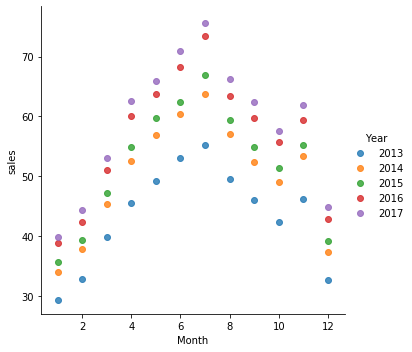

In [80]:
temp_1 = df_train.groupby(['Year','Month'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.lmplot('Month','sales',data = temp_1, hue='Year', fit_reg= False);

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 864x576 with 0 Axes>

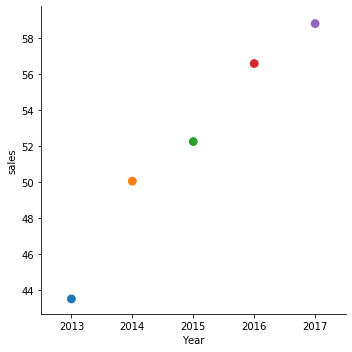

In [81]:
temp_1 = df_train.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.factorplot('Year','sales',data = temp_1, hue='Year', kind='point');

In [ ]:
As can be seen the year over year sales has been increasing.

In [87]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [88]:
doing box-cox transformation of the target variable, y

original_target = df_train.sales.values
target, lambda_prophet = stats.boxcox(df_train['sales'] + 1)
len_train=target.shape[0]
merged_df = pd.concat([df_train, df_test])#i don't usually do the preprocessing step combining the train and test datasets but following for now




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [89]:
lambda_prophet

0.26166671549165516

In [91]:
target.shape

(913000,)

In [92]:
wanted to check the outcome of stats.boxcox
stats.boxcox(df_train['sales'] + 1)

(array([3.80185644, 3.50047287, 3.94073457, ..., 8.00583601, 7.47836041,
        8.32370427]), 0.26166671549165516)

In [96]:
#feature engineering


merged_df["median-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("median")
merged_df["mean-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("mean")
merged_df["mean-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("mean")
merged_df["median-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("median")
merged_df["median-Month_store"] = merged_df.groupby(["Month", "store"])["sales"].transform("median")
merged_df["median-item"] = merged_df.groupby(["item"])["sales"].transform("median")
merged_df["median-store"] = merged_df.groupby(["store"])["sales"].transform("median")
merged_df["mean-item"] = merged_df.groupby(["item"])["sales"].transform("mean")
merged_df["mean-store"] = merged_df.groupby(["store"])["sales"].transform("mean")

merged_df["median-store_item-Month"] = merged_df.groupby(['Month', "item", "store"])["sales"].transform("median")
merged_df["mean-store_item-week"] = merged_df.groupby(["item", "store",'weekofyear'])["sales"].transform("mean")
merged_df["item-Month-mean"] = merged_df.groupby(['Month', "item"])["sales"].transform("mean")# mean sales of that item  for all stores scaled
merged_df["store-Month-mean"] = merged_df.groupby(['Month', "store"])["sales"].transform("mean")# mean sales of that store  for all items scaled

# adding more lags (Check the rationale behind this in the links attached)
lags = [90,91,98,105,112,119,126,182,189,364]
for i in lags:
#     print("Done For Lag {}".format(i))
    merged_df['_'.join(['item-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(i).sum()) 
    merged_df['_'.join(['item-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(i).mean()) 
    merged_df['_'.join(['item-week_shifted-', str(i)])].fillna(merged_df['_'.join(['item-week_shifted-', str(i)])].mode()[0], inplace=True)
    ##### sales for that item i days in the past
    merged_df['_'.join(['store-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(i).sum())
    merged_df['_'.join(['store-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(i).mean()) 
    merged_df['_'.join(['store-week_shifted-', str(i)])].fillna(merged_df['_'.join(['store-week_shifted-', str(i)])].mode()[0], inplace=True)

In [101]:
len(merged_df.columns)

51

In [98]:
merged_df.head()

,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,...,item-week_shifted-_119,store-week_shifted-_119,item-week_shifted-_126,store-week_shifted-_126,item-week_shifted-_182,store-week_shifted-_182,item-week_shifted-_189,store-week_shifted-_189,item-week_shifted-_364,store-week_shifted-_364
0,1,1,1,False,True,False,True,False,True,1,...,14.62543,32.529412,14.524648,32.529412,14.131579,32.529412,14.285068,32.529412,14.717391,32.425267
1,2,2,2,False,False,False,False,False,False,1,...,14.62543,32.529412,14.524648,32.529412,14.131579,32.529412,14.285068,32.529412,14.717391,32.425267
2,3,3,3,False,False,False,False,False,False,1,...,14.62543,32.529412,14.524648,32.529412,14.131579,32.529412,14.285068,32.529412,14.717391,32.425267
3,4,4,4,False,False,False,False,False,False,1,...,14.62543,32.529412,14.524648,32.529412,14.131579,32.529412,14.285068,32.529412,14.717391,32.425267
4,5,5,5,False,False,False,False,False,False,1,...,14.62543,32.529412,14.524648,32.529412,14.131579,32.529412,14.285068,32.529412,14.717391,32.425267


In [100]:
merged_df.columns

Index(['Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Month', 'Week', 'Year', 'date', 'id', 'item', 'sales', 'store',
       'weekofyear', 'median-store_item', 'mean-store_item', 'mean-Month_item',
       'median-Month_item', 'median-Month_store', 'median-item',
       'median-store', 'mean-item', 'mean-store', 'median-store_item-Month',
       'mean-store_item-week', 'item-Month-mean', 'store-Month-mean',
       'item-week_shifted-_90', 'store-week_shifted-_90',
       'item-week_shifted-_91', 'store-week_shifted-_91',
       'item-week_shifted-_98', 'store-week_shifted-_98',
       'item-week_shifted-_105', 'store-week_shifted-_105',
       'item-week_shifted-_112', 'store-week_shifted-_112',
       'item-week_shifted-_119', 'store-week_shifted-_119',
       'item-week_shifted-_126', 'store-week_shifted-_126',
       'item-week_shifted-_182', 'store-week_shifted-_182',
       'ite

In [105]:
# comes from the public kernel
# merged_df = merged_df * 1
params = {
    'nthread': 4,
    'categorical_feature' : [0,1,9,10,12,13,14], # Day, DayOfWeek, Month, Week, Item, Store, WeekOfYear
    'max_depth': 8,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 127,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 30,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}



In [ ]:
# do the training
num_folds = 3
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target # removing what we did earlier

oof_preds = np.zeros([all_y.shape[0]])
sub_preds = np.zeros([test_x.shape[0]])

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=num_folds, shuffle=True, random_state=345665)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
    
    train_x, train_y = all_x[train_idx], all_y[train_idx]
    valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
        
    # train
    gbm = lgb.train(params, lgb_train, 1000, 
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100, verbose_eval=100)
    
    oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    sub_preds[:] += gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_idx += 1
    importance_df = pd.DataFrame()
    importance_df['feature'] = merged_df.columns
    importance_df['importance'] = gbm.feature_importance()
    importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)
    
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score With Box Cox %.4f' %e)
print('Inverting Box Cox Transformation')
print('Done!!')

sub_preds = inverse_boxcox(sub_preds , lambda_prophet) - 1
oof_preds = inverse_boxcox(oof_preds , lambda_prophet) - 1
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score Re-Box Cox Transformation is %.4f' %e)
#Don't Forget to apply inverse box-cox

In [ ]:
Prophet
(From the Docs Itself)

# let's take a closer look at how Prophet works. In its essence, this library utilizes the additive regression model $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$ where:

Trend $g(t)$ models non-periodic changes.
Seasonality $s(t)$ represents periodic changes.
Holidays component $h(t)$ contributes information about holidays and events.
Trend $g(t)$

The Prophet library implements two possible trend models for $g(t)$.

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$ where:

$C$ is the carrying capacity (that is the curve's maximum value).
$k$ is the growth rate (which represents "the steepness" of the curve).
$m$ is an offset parameter.
Seasonality $s(t)$

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality. Yearly seasonality model in Prophet relies on Fourier series.

Holidays and Events $h(t)$

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

Error $\epsilon(t)$

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In describing these time series, we have used words such as $“trend”$ and $“seasonal”$ which need to be defined more carefully.

Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.

Seasonal
A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.

Cycle
A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

In [ ]:
# Prophet

let's take a closer look at how Prophet works. In its essence, this library utilizes the additive regression model $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$ where:

Trend $g(t)$ models non-periodic changes.
Seasonality $s(t)$ represents periodic changes.
Holidays component $h(t)$ contributes information about holidays and events.
Trend $g(t)$

The Prophet library implements two possible trend models for $g(t)$.

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$ where:

$C$ is the carrying capacity (that is the curve's maximum value).
$k$ is the growth rate (which represents "the steepness" of the curve).
$m$ is an offset parameter.
Seasonality $s(t)$

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality. Yearly seasonality model in Prophet relies on Fourier series.

Holidays and Events $h(t)$

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

Error $\epsilon(t)$

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In describing these time series, we have used words such as $“trend”$ and $“seasonal”$ which need to be defined more carefully.

Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.

Seasonal
A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.

Cycle
A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.


In [106]:
date_sales.head()

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0


In [107]:
df = date_sales.reset_index()
df.columns = ['ds', 'y']

In [108]:
df.head()

,ds,y
0,2013-01-01,13.0
1,2013-01-02,11.0
2,2013-01-03,14.0
3,2013-01-04,13.0
4,2013-01-05,10.0


In [109]:
df['store'] = df_train['store'].copy()
df['Week'] = df_train['Week'].copy()
df['item'] = df_train['item'].copy()

In [110]:
df = df.query('item == 1 & store == 1')

In [111]:
df.groupby(['Week','store','item'])['y'].mean().reset_index().head(15)

,Week,store,item,y
0,1,1,1,13.970588
1,2,1,1,13.200000
2,3,1,1,14.114286
3,4,1,1,13.828571
4,5,1,1,14.342857
5,6,1,1,14.114286
6,7,1,1,15.228571
7,8,1,1,14.371429
8,9,1,1,15.342857
9,10,1,1,15.771429


In [112]:
len(df)

1826

In [ ]:
We are good to go:
The authors of the library generally advise to make predictions based on at least several months, ideally, more than a year of historical data. Luckily, in our case we have more than a couple of years of data to fit the model.

split the dataset, df into historic part to predict upon and the other one to validate the predicted results with.
To measure the quality of our forecast, we need to split our dataset into the historical part and the prediction part... (We should have done this)

In [113]:
prediction_size = 31 
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y,store,Week,item
1792,2017-11-28,14.0,1,48,1
1793,2017-11-29,28.0,1,48,1
1794,2017-11-30,15.0,1,48,1


In [114]:
# Now we need to create a new Prophet object. Here we can pass the parameters of the model into the constructor.
# But currently we will use the defaults as it is.. Then we train our model by invoking its fit method on our training
# dataset:

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds','y']]);

In [116]:


future = m.make_future_dataframe(periods=prediction_size)
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [117]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.474896,12.873257,24.231169,20.474085,20.475722,-2.056775,-2.056775,-2.056775,2.272898,...,1.120657,1.120657,1.120657,-5.450330,-5.450330,-5.450330,0.0,0.0,0.0,18.418121
1824,2017-12-30,20.476881,14.934263,26.390855,20.475960,20.477842,-0.108707,-0.108707,-0.108707,2.272898,...,2.993410,2.993410,2.993410,-5.375015,-5.375015,-5.375015,0.0,0.0,0.0,20.368173
1825,2017-12-31,20.478865,15.688713,27.242682,20.477851,20.479869,0.737724,0.737724,0.737724,2.272898,...,3.780476,3.780476,3.780476,-5.315651,-5.315651,-5.315651,0.0,0.0,0.0,21.216589


In [118]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,13.562954,2.982758,14.333199,13.562954,13.562954,-4.765262,-4.765262,-4.765262,2.272898,...,-1.772798,-1.772798,-1.772798,-5.265362,-5.265362,-5.265362,0.0,0.0,0.0,8.797692
1,2013-01-02,13.568090,3.889753,15.332591,13.568090,13.568090,-4.146730,-4.146730,-4.146730,2.272898,...,-1.174933,-1.174933,-1.174933,-5.244695,-5.244695,-5.244695,0.0,0.0,0.0,9.421360
2,2013-01-03,13.573226,4.434772,15.796824,13.573226,13.573226,-3.474978,-3.474978,-3.474978,2.272898,...,-0.506733,-0.506733,-0.506733,-5.241143,-5.241143,-5.241143,0.0,0.0,0.0,10.098248
3,2013-01-04,13.578362,6.043458,17.000860,13.578362,13.578362,-1.860322,-1.860322,-1.860322,2.272898,...,1.120657,1.120657,1.120657,-5.253877,-5.253877,-5.253877,0.0,0.0,0.0,11.718041
4,2013-01-05,13.583499,7.816169,18.981748,13.583499,13.583499,-0.015268,-0.015268,-0.015268,2.272898,...,2.993410,2.993410,2.993410,-5.281576,-5.281576,-5.281576,0.0,0.0,0.0,13.568230


In [ ]:
In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the yhat column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result.

First, there is a method called Prophet.plot that plots all the points from the forecast:
The Second function Prophet.plot_components might be much more useful in our case. It allows us to observe different components of the model separately: trend, yearly and weekly seasonality. In addition, if you supply information about holidays and events to your model, they will also be shown in this plot.
# Let's try it out:

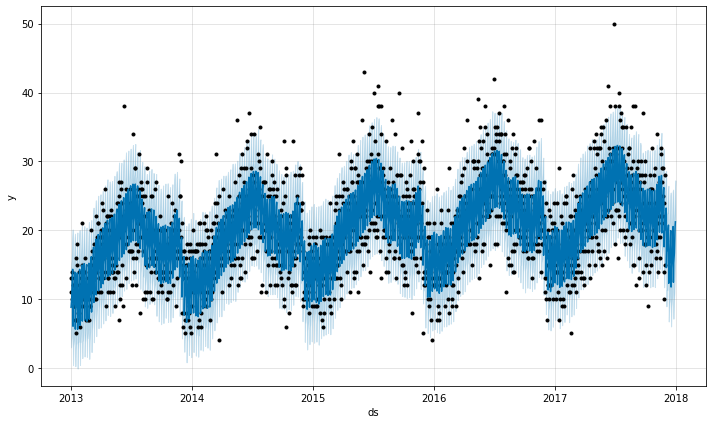

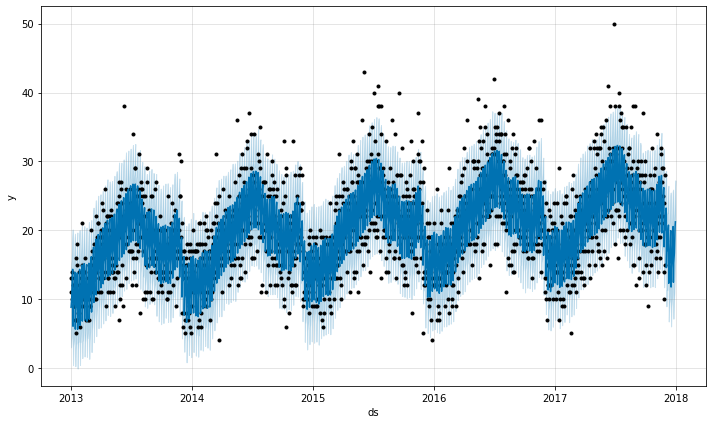

In [120]:
m.plot(forecast)


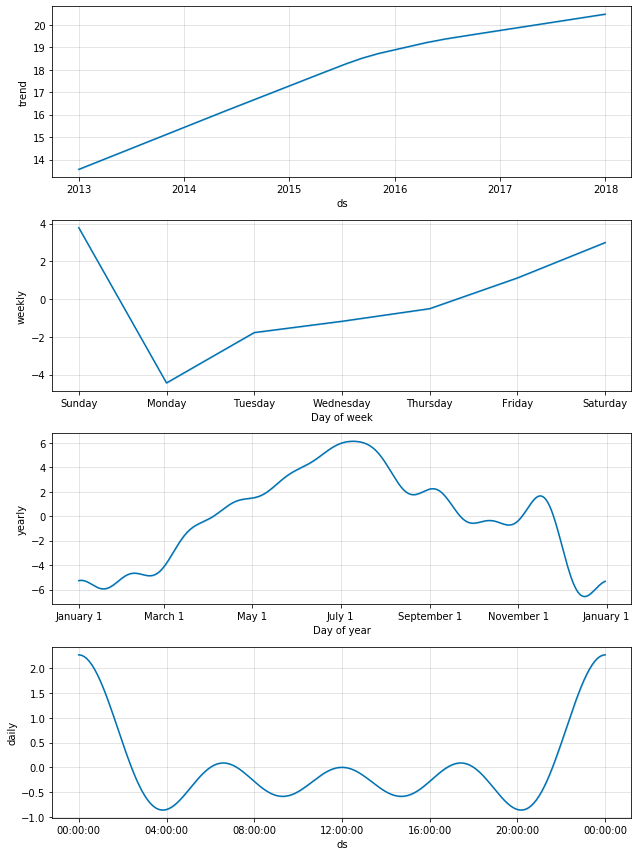

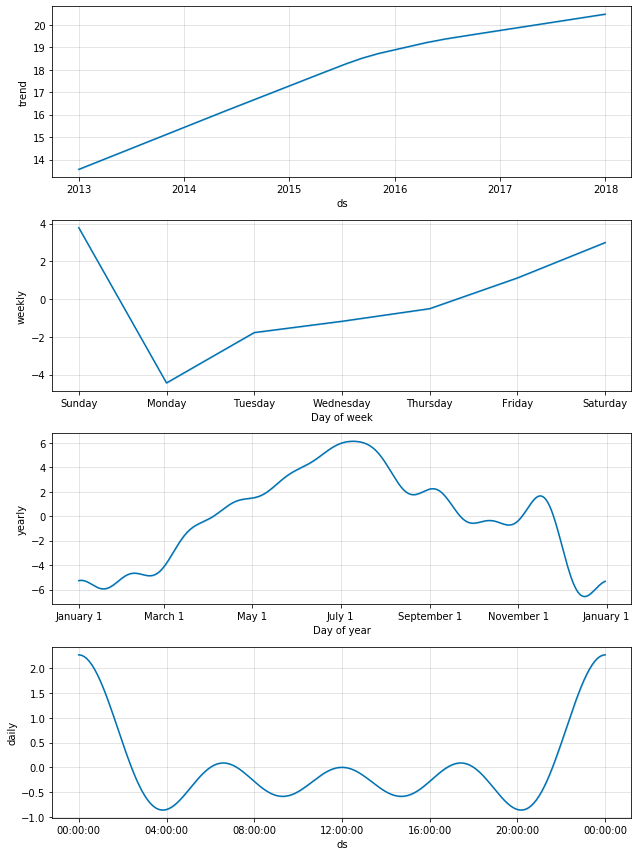

In [121]:
m.plot_components(forecast)

In [ ]:
The last Weekly Plot Says it All (third plot from bottom up)

Seems like People go to Shopping Mostly in July
Have a look at the peak at Sundays and Saturdays (3rd Plot)
So we should add the holidays effect to make Prohet perform better.

In [122]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [123]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,playoff,2013-01-12,0,2
1,playoff,2013-07-12,0,2
2,playoff,2013-12-24,0,2
3,playoff,2014-01-12,0,2
4,playoff,2014-07-12,0,2


In [124]:
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(train_df[['ds','y']]);

In [125]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [126]:
# The holiday effect can be seen in the forecast dataframe:
    
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.490263,12.811277,24.358277,20.489562,20.491161,-1.991866,-1.991866,-1.991866,2.274483,...,1.115697,1.115697,1.115697,-5.382046,-5.382046,-5.382046,0.0,0.0,0.0,18.498397
1824,2017-12-30,20.492258,14.692329,26.241921,20.491393,20.493249,-0.033080,-0.033080,-0.033080,2.274483,...,2.998522,2.998522,2.998522,-5.306084,-5.306084,-5.306084,0.0,0.0,0.0,20.459178
1825,2017-12-31,20.494253,15.802492,27.192417,20.493203,20.495296,0.807840,0.807840,0.807840,2.274483,...,3.780327,3.780327,3.780327,-5.246970,-5.246970,-5.246970,0.0,0.0,0.0,21.302093


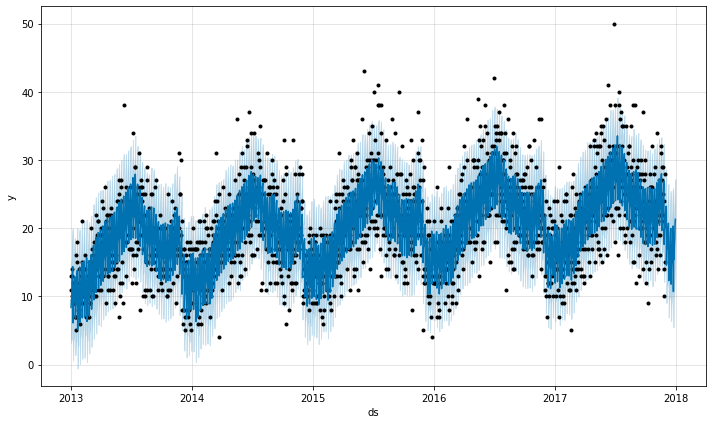

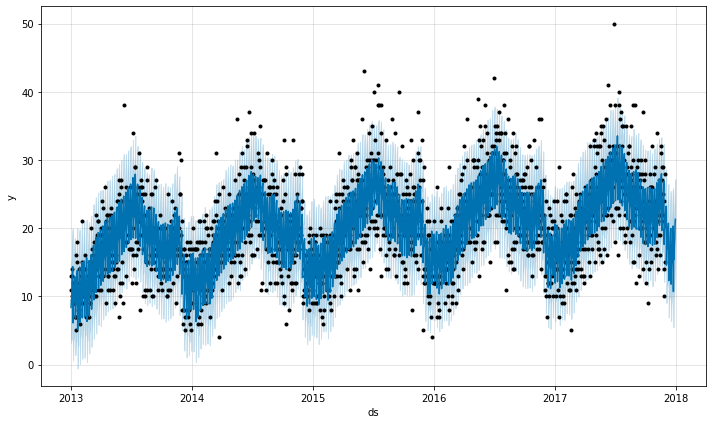

In [127]:
m_holi.plot(forecast_holi)


In [ ]:
The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

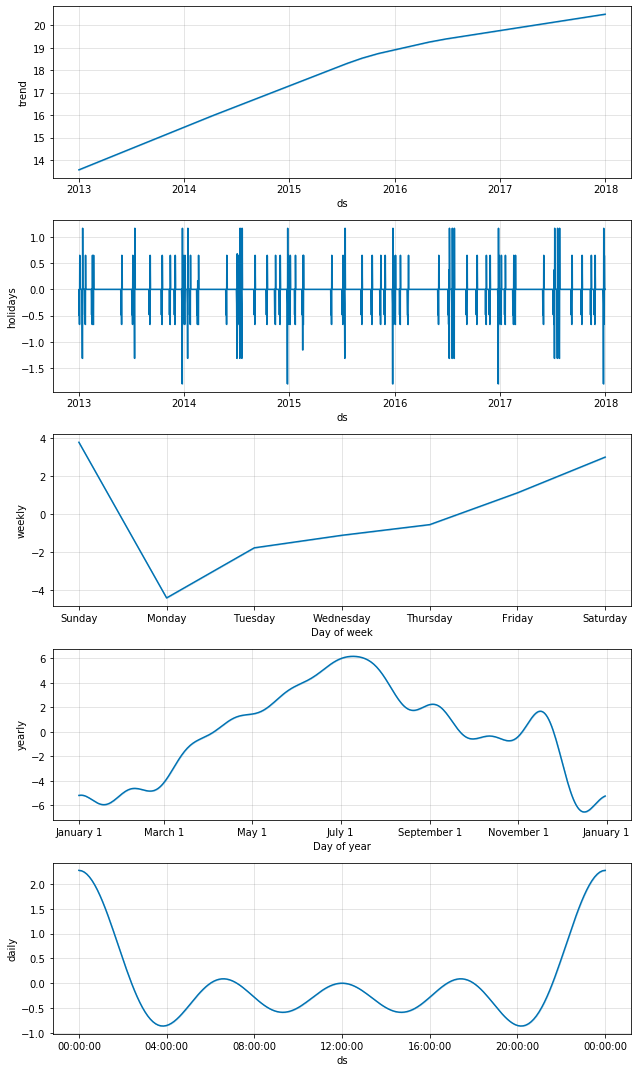

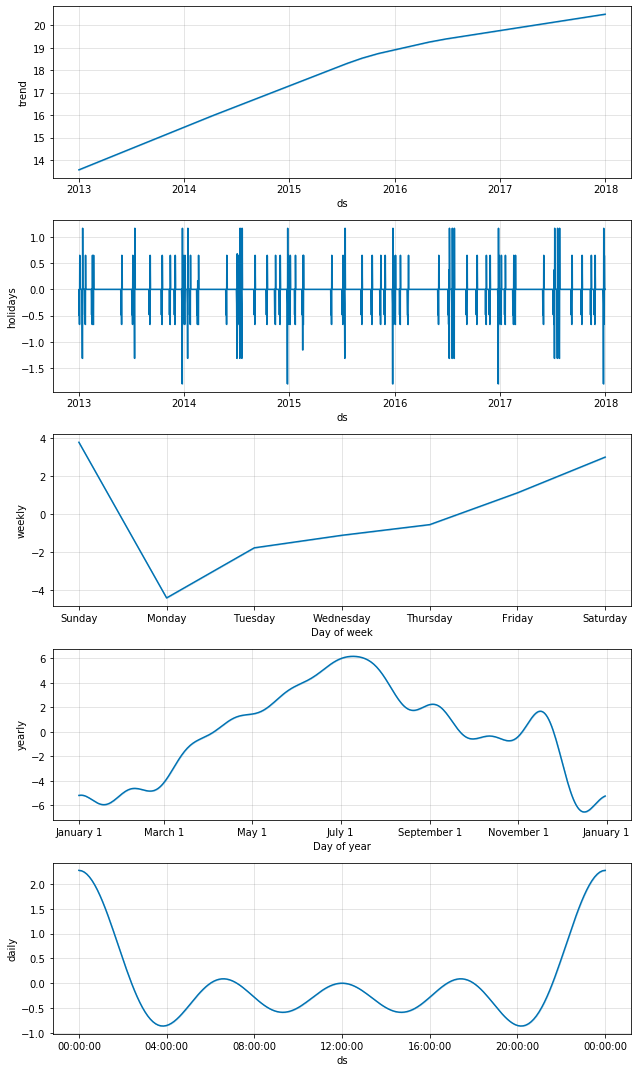

In [128]:
m_holi.plot_components(forecast_holi)